In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np
import pickle
from glob import glob
import corner
from math import floor, log10
from ebola import Ebola

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})

In [4]:
par = ('beta', 'k', 'tau', 'sigma', 'gamma', 'f', 'offset')
ndim = len(par)  # number of parameters in the model
N = 1000000

In [5]:
country = 'guinea'
#country = 'liberia'
#country = 'sierraleone'

In [6]:
binning = 'hybrid'

In [7]:
e = Ebola(N, country)

In [8]:
filename = '{}/logs/{}/run3/chains/chain.txt'.format(binning, country)
print(filename)

hybrid/logs/guinea/run3/chains/chain.txt


In [9]:
data = np.loadtxt(filename)

In [10]:
chain = data[:, 2:]
lnprob = -data[:, 1]
weight = data[:, 0]
###weight = weight * 0 + 1
weight /= weight.sum()

In [11]:
chain.shape

(2558, 7)

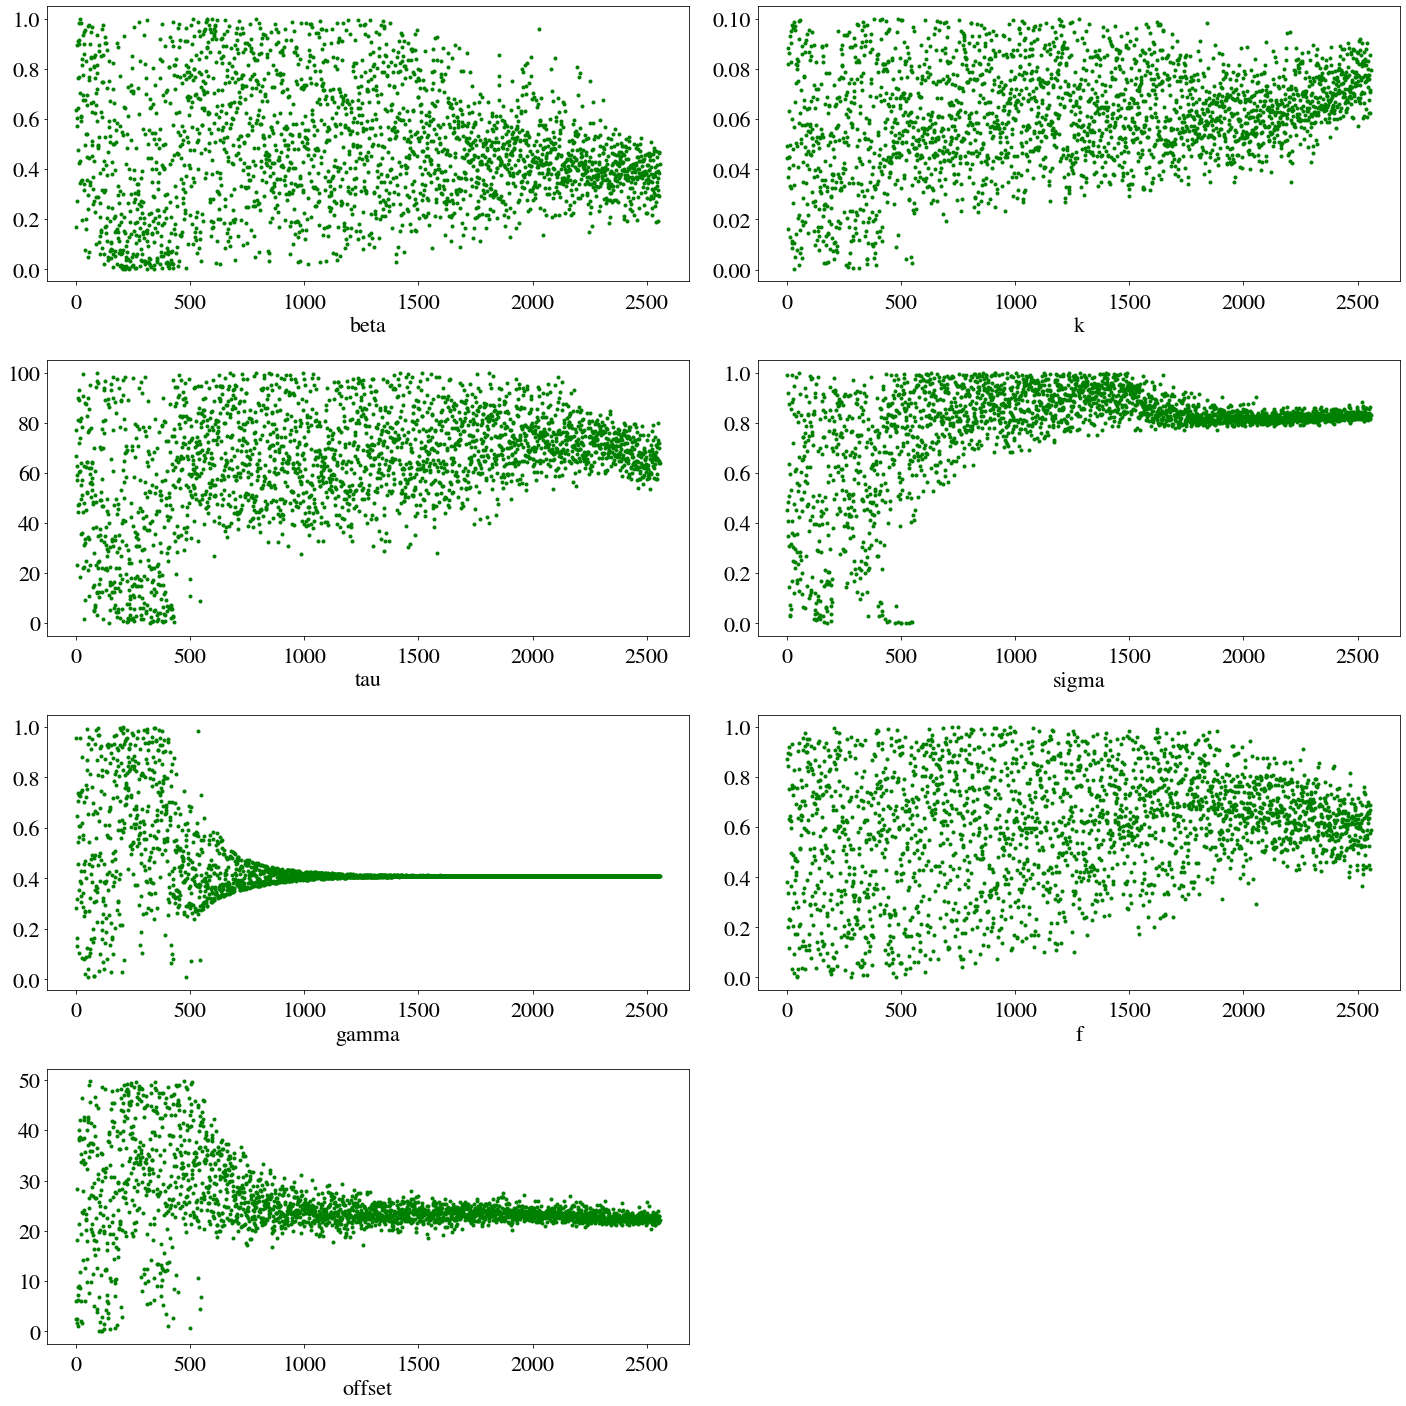

In [12]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    plt.plot(np.arange(chain.shape[0]), chain[:,i], 'g.')
    plt.xlabel(p)
    aymin, aymax = plt.ylim()
    plt.ylim(aymin, aymax)
    plt.tight_layout()
plt.savefig('plots/nnest_all_chains_{}.pdf'.format(country))

In [13]:
def round_sig(x, sig=1):
    d = sig-int(floor(log10(x)))-1
    d = max(0, d)
    return round(x, d), d


def summary(samples, truths=None, filename=None, weight=None):
    mean = np.average(samples, axis=0, weights=weight)
    sigma = np.sqrt(np.average((samples-mean)**2, axis=0, weights=weight))
    if filename is not None:
        f = open(filename, 'a')
    else:
        f = None
    for i, p in enumerate(par):
        err, dp = round_sig(sigma[i], 1)
        val = round(mean[i], dp)
        dp = str(dp)
        dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        outstr = ('{:22s} = {:6.'+dp+' ± {:<8.'+dp).format(p, val, err)
        if truths is not None:
            outstr += ('   ('+dp+')').format(truths[i])
        print(outstr, file=f)
    if filename is not None:
        f.close()

In [14]:
summary(chain)
summary(chain, filename='nest_summary_{}'.format(country))

beta                   =    0.5 ± 0.2     
k                      =   0.06 ± 0.02    
tau                    =     64 ± 21      
sigma                  =    0.8 ± 0.2     
gamma                  =    0.4 ± 0.1     
f                      =    0.6 ± 0.2     
offset                 =     25 ± 7       


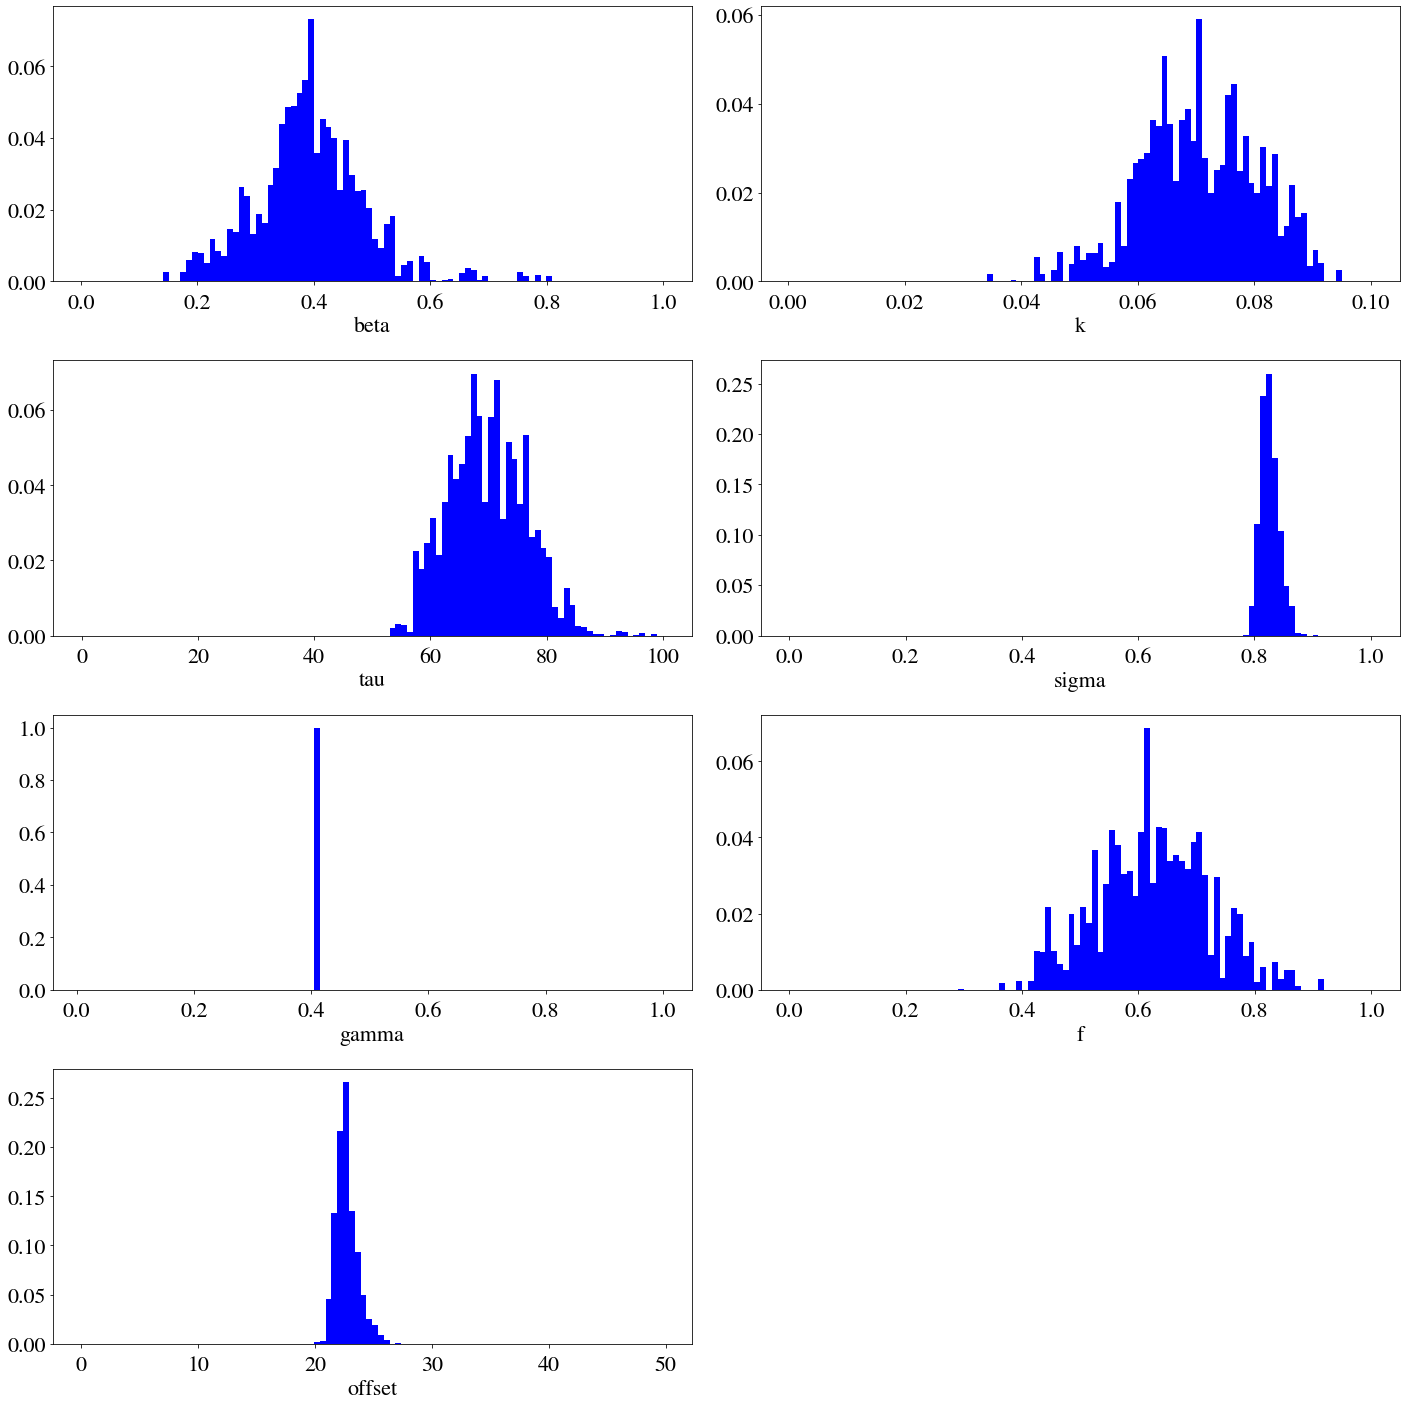

In [15]:
# examine parameter histograms
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    n, b, patches = plt.hist(chain[:,i], weights=weight, bins=100, color='b', histtype='stepfilled', log=False)
    plt.xlabel(p)
    plt.tight_layout()
plt.savefig('plots/nnest_param_hist_{}.pdf'.format(country))

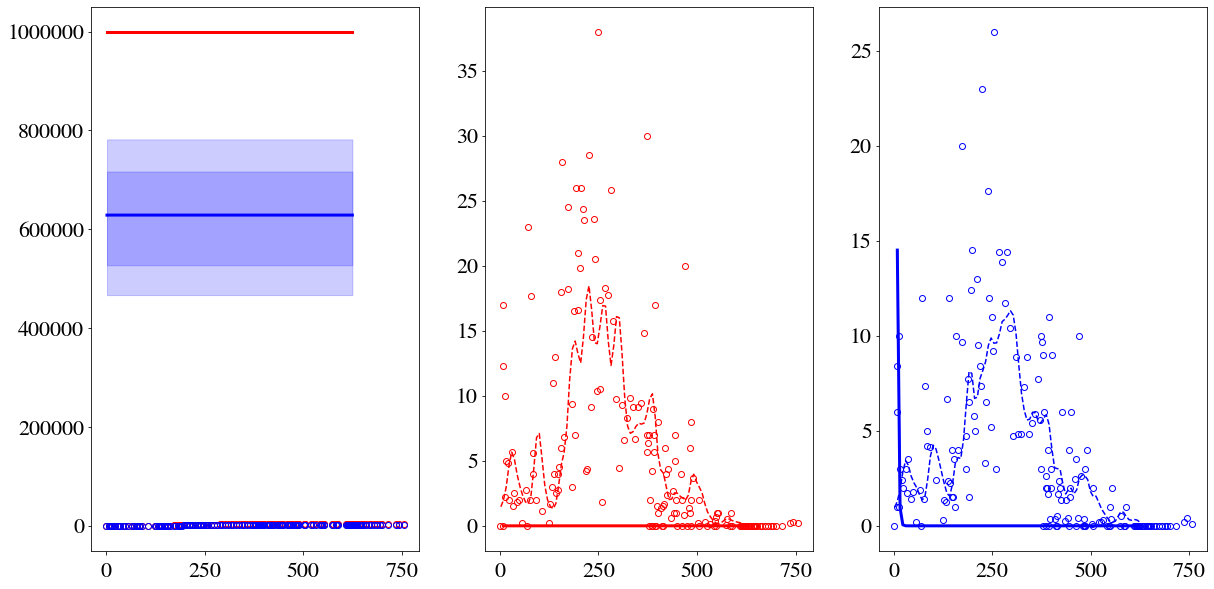

In [16]:
selection = np.random.choice(len(chain), 1000, replace=True, p=weight)
e.makeplot(samples=chain[selection])
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/nnest_fit_intervals_{}.pdf'.format(country))

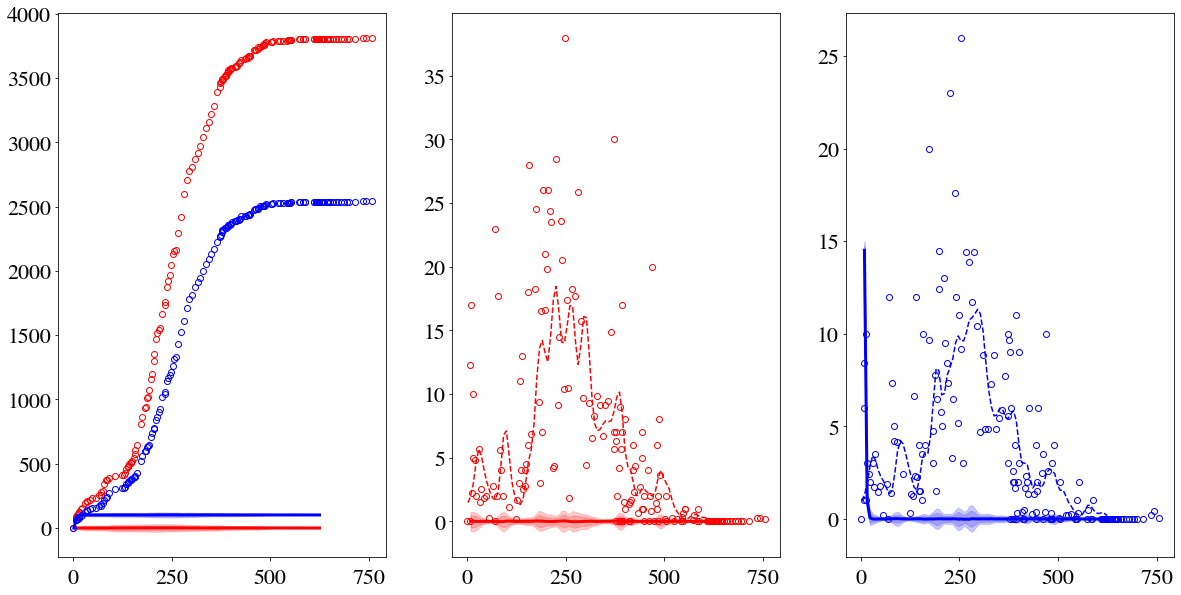

In [17]:
e.makeplot(samples=chain[selection], scatter=True)
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/nnest_fit_intervals_scatter_{}.pdf'.format(country))

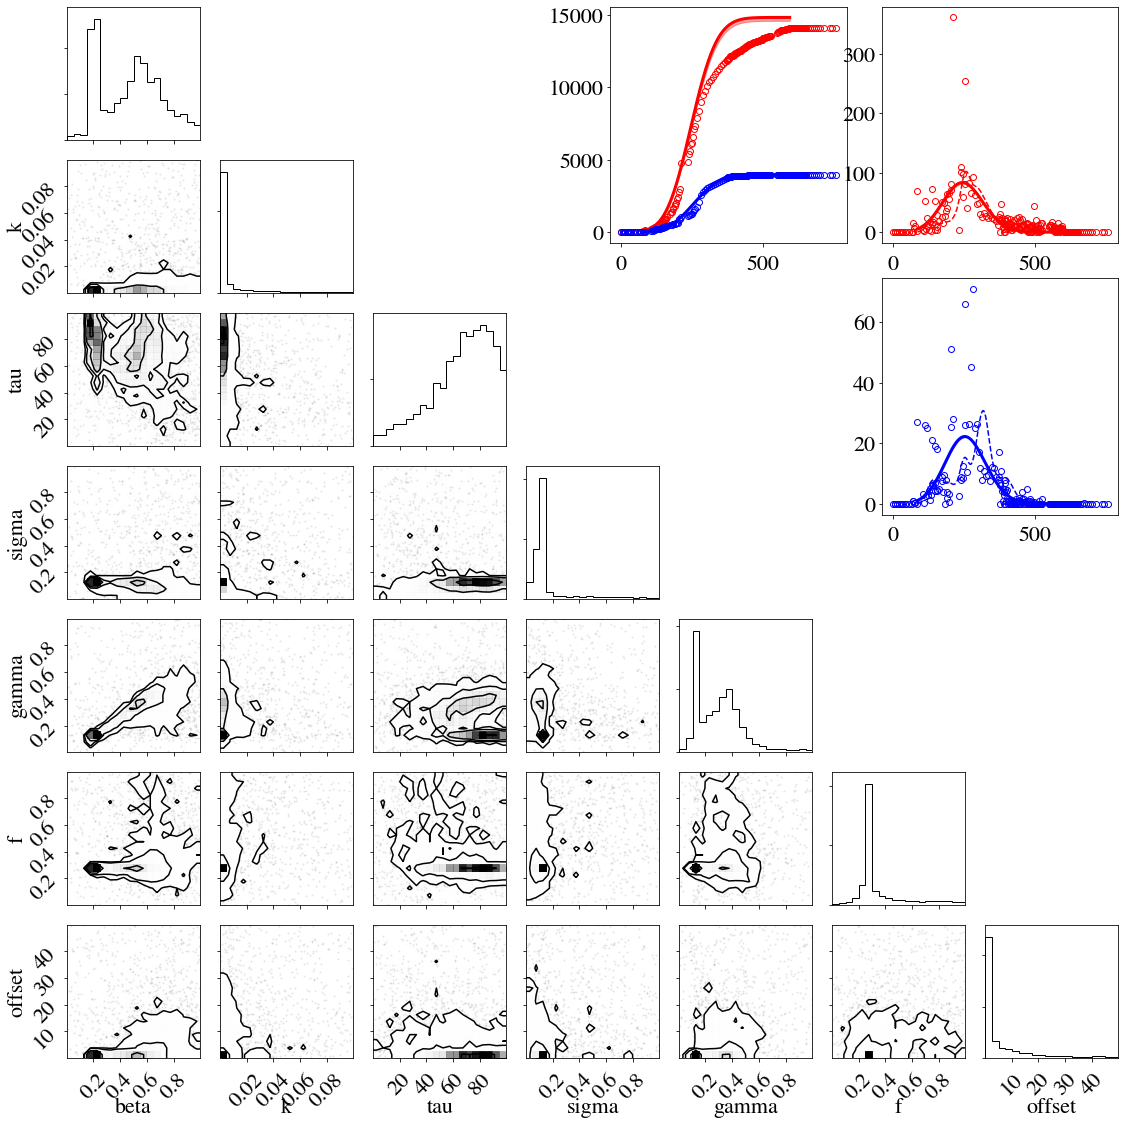

In [53]:
corner.corner(chain, labels=par)
ax0 = plt.subplot(4, 4, 3)
ax1 = plt.subplot(4, 4, 4)
ax2 = plt.subplot(4, 4, 8)
selection = np.random.choice(len(chain), 1000, replace=True, p=weight)
e.makeplot(samples=chain[selection], ax=(ax0, ax1, ax2))
plt.subplots_adjust(wspace=0.15, hspace=0.15);
plt.savefig('plots/nnest_corner_{}.pdf'.format(country))

In [25]:
lnprob[-1]

440.614

In [20]:
chain[-1]

array([8.13446e-01, 2.79732e-03, 5.09541e+01, 4.26002e-02, 4.25685e-01,
       6.65953e-01, 1.25073e+00])

((425.0292475367148, 108.45452953591894, 316.5747180007959),
 -12.493413494689309,
 array([412.53583404,  95.96111604, 304.08130451]))

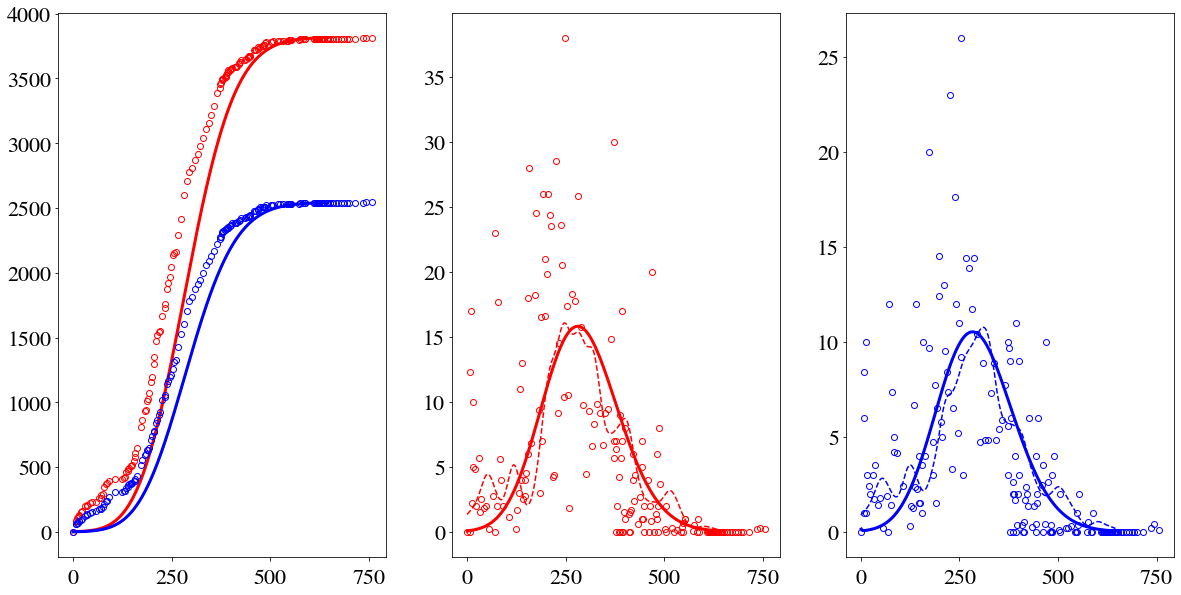

In [21]:
p = chain[-1]
#p = [0.77424, 3.66322e-03, 0.14690e+01, 6.35830e-02, 3.61628e-01,
#       6.62632e-01, 9.02731e+00]
e.makeplot([p])
e.log_like(p), e.log_prior(p), e(p)

In [64]:
from scipy.stats import multivariate_normal as mvnorm
x1 = np.linspace(0, 5, 11)
x2 = np.linspace(5, 0, 11)

y = mvnorm.pdf(np.transpose((x1, x2)), mean=(2.5, 2.5), cov=[[0.5, 0.49], [0.49, 0.5]]); y

array([5.88777689e-272, 3.06344278e-174, 3.07428486e-098, 5.95051212e-044,
       2.22147017e-011, 1.59956736e+000, 2.22147017e-011, 5.95051212e-044,
       3.07428486e-098, 3.06344278e-174, 5.88777689e-272])